# Manejo de datos raster

## Descripción general

En este capítulo, se muestran ejemplos de manejo de datos raster con Python.

Los datos se obtienen de servicios basados en la especificación [SpatioTemporal Asset Catalogs (STAC)](https://stacspec.org), la cual proporciona una estructura común para describir y catalogar recursos espacio temporales (ej. imágenes satelitales) a través de una interfaz de programación de aplicaciones (en inglés, [API o *Application Programming Interface*](https://es.wikipedia.org/wiki/Interfaz_de_programaci%C3%B3n_de_aplicaciones)). Puede explorar catálogos y API de tipo STAC en el sitio web [STAC browser](https://radiantearth.github.io/stac-browser/).

## Instalación de módulos

Algunos de los módulos que se utilizan en este capítulo son:

- [rasterio](https://rasterio.readthedocs.io/): para operaciones generales de manejo de datos raster.
- [xarray](https://docs.xarray.dev/): para manejo de arreglos multidimensionales.
- [rioxarray](https://corteva.github.io/rioxarray/stable/): extensión de xarray para trabajar con rasterio. 
- [pystac_client](https://pystac-client.readthedocs.io/): para trabajar con catálogos STAC.

```
# Instalación, mediante mamba, de módulos para manejo de datos raster y acceso a recursos STAC
mamba install -c conda-forge xarray rioxarray earthpy xarray-spatial pystac-client python-graphviz
```

## Lectura

### Acceso a recursos STAC

In [1]:
# Carga de pystac_client, para acceder datos en STAC
from pystac_client import Client

Se accede el API de [Earth Search](https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v0), el cual proporciona acceso a conjuntos de datos públicos en Amazon Web Services (AWS).

La función [Client.open()](https://pystac-client.readthedocs.io/en/stable/api.html#pystac_client.Client.open) retorna un objeto tipo `Client`, el cual se utiliza para acceder el API (ej. realizar búsquedas). 

In [2]:
# URL del API STAC
api_url = "https://earth-search.aws.element84.com/v0"

# Cliente para acceso a los datos
client = Client.open(api_url)

En este ejemplo, se accederá una colección de imágenes Sentinel en formato [Cloud Optimized GeoTIFF (COG)](https://www.cogeo.org/).

In [3]:
# Colección
collection = "sentinel-s2-l2a-cogs"

Se especifica un punto (x, y) para buscar imágenes que lo contengan.

In [4]:
# Punto para búsqueda
from shapely.geometry import Point
point = Point(-84, 10)

La función [Client.search()](https://pystac-client.readthedocs.io/en/stable/api.html#pystac_client.Client.search) realiza una búsqueda con base en criterios como colección e intersección.

In [5]:
# Búsqueda de items (imágenes) que contienen el punto
search = client.search(collections=[collection],
                       intersects=point,
                       max_items=10,
)

In [6]:
# Cantidad total de items que retorna la búsqueda
search.matched()

368

In [7]:
# Items retornados
items = search.get_all_items()

len(items)

10

In [8]:
# Identificadores de los items retornados
for item in items:
    print(item)

<Item id=S2A_16PHS_20221116_0_L2A>
<Item id=S2B_16PHS_20221111_0_L2A>
<Item id=S2A_16PHS_20221106_0_L2A>
<Item id=S2B_16PHS_20221101_0_L2A>
<Item id=S2A_16PHS_20221027_0_L2A>
<Item id=S2B_16PHS_20221022_0_L2A>
<Item id=S2A_16PHS_20221017_0_L2A>
<Item id=S2B_16PHS_20221012_0_L2A>
<Item id=S2A_16PHS_20221007_0_L2A>
<Item id=S2B_16PHS_20221002_0_L2A>


Para estudiarlo en detalle, se selecciona un item.

In [9]:
# Primer item (imagen) retornado
item = items[0]

**Nótese que al seleccionarse el item mediante una posición en una colección, la imagen correspondiente puede cambiar si se actualizan los datos del API**.

In [10]:
# Algunos atributos del item
print(item.id)
print(item.datetime)
print(item.geometry)
print(item.properties)

S2A_16PHS_20221116_0_L2A
2022-11-16 16:10:34+00:00
{'type': 'Polygon', 'coordinates': [[[-83.26529071959975, 9.841749072035094], [-84.26505426889273, 9.85133238997552], [-84.2564449365329, 10.843245515578994], [-83.25354975084628, 10.83267581874028], [-83.26529071959975, 9.841749072035094]]]}
{'datetime': '2022-11-16T16:10:34Z', 'platform': 'sentinel-2a', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'gsd': 10, 'view:off_nadir': 0, 'proj:epsg': 32616, 'sentinel:utm_zone': 16, 'sentinel:latitude_band': 'P', 'sentinel:grid_square': 'HS', 'sentinel:sequence': '0', 'sentinel:product_id': 'S2A_MSIL2A_20221116T160511_N0400_R054_T16PHS_20221116T210453', 'sentinel:data_coverage': 100, 'eo:cloud_cover': 96.75, 'sentinel:valid_cloud_cover': True, 'sentinel:processing_baseline': '04.00', 'sentinel:boa_offset_applied': True, 'created': '2022-11-16T23:20:31.881Z', 'updated': '2022-11-16T23:20:31.881Z'}


Ahora, se realiza la búsqueda con base en un rectángulo delimitador (*bounding box*) generado a partir del punto que se definió anteriormente.

In [11]:
# Rectángulo para búsquedas
bbox = point.buffer(0.01).bounds
bbox

(-84.01, 9.99, -83.99, 10.01)

También se restringe la búsqueda para retornar solo aquellas imágenes con cobertura de nubes menor al 10%.

In [12]:
# Búsqueda con nuevos criterios
search = client.search(collections=[collection],
                       bbox=bbox,
                       datetime="2022-01-01/2022-10-30",
                       query=["eo:cloud_cover<10"]) # no deben haber espacios alrededor del '<'

# Cantidad total de items que retorna la búsqueda
search.matched()

5

In [13]:
# Items retornados
items = search.get_all_items()

len(items)

5

In [14]:
# Segundo item retornado y algunos de sus atributos
item = items[1]

print(item.datetime)
print(item.properties)

2022-06-04 16:10:32+00:00
{'datetime': '2022-06-04T16:10:32Z', 'platform': 'sentinel-2b', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'gsd': 10, 'view:off_nadir': 0, 'proj:epsg': 32616, 'sentinel:utm_zone': 16, 'sentinel:latitude_band': 'P', 'sentinel:grid_square': 'HS', 'sentinel:sequence': '0', 'sentinel:product_id': 'S2B_MSIL2A_20220604T160509_N0400_R054_T16PHS_20220604T202130', 'sentinel:data_coverage': 100, 'eo:cloud_cover': 5.33, 'sentinel:valid_cloud_cover': True, 'sentinel:processing_baseline': '04.00', 'sentinel:boa_offset_applied': True, 'created': '2022-06-05T01:47:01.875Z', 'updated': '2022-06-05T01:47:01.875Z'}


#### Ejercicio

Realice el [ejercicio de búsqueda de imágenes Landsat 8](https://carpentries-incubator.github.io/geospatial-python/05-access-data/index.html#exercise-downloading-landsat-8-assets) del curso [The Carpentries Incubator - Introduction to Geospatial Raster and Vector Data with Python](https://carpentries-incubator.github.io/geospatial-python/). Puede cambiar el punto de la búsqueda por otro que sea de su interés.

In [21]:
# URL del API STAC
api_url_landsat = "https://cmr.earthdata.nasa.gov/stac/LPCLOUD"

# Cliente para acceso a los datos
client_landsat = Client.open(api_url_landsat)


collection_landsat = "HLSL30.v2.0"

point_landsat = Point(-84, 10)

search_landsat = client_landsat.search(collections=[collection_landsat], 
                                       intersects=point_landsat)

search_landsat.matched()

219

In [22]:
items_landsat = search_landsat.get_all_items()

len(items_landsat)

219

In [34]:
i = 0

for item_landsat in items_landsat:
    if (item_landsat.properties["eo:cloud_cover"] < 20):
        print(i, item_landsat.id, item_landsat.properties["eo:cloud_cover"])
    i += 1

79 HLS.L30.T16PHS.2017026T155406.v2.0 10
188 HLS.L30.T16PHS.2022048T155411.v2.0 15


In [37]:
item_landsat = items_landsat[188]
item_landsat

ID: HLS.L30.T16PHS.2022048T155411.v2.0
"Bounding Box: [-84.265063, 9.84174, -83.25354, 10.843255]"
Datetime: 2022-02-17 15:54:11.506000+00:00
eo:cloud_cover: 15
datetime: 2022-02-17T15:54:11.506Z
start_datetime: 2022-02-17T15:54:11.506Z
end_datetime: 2022-02-17T15:54:35.414Z
stac_extensions: ['https://stac-extensions.github.io/eo/v1.0.0/schema.json']
https://stac-extensions.github.io/eo/v1.0.0/schema.json
href: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16PHS.2022048T155411.v2.0/HLS.L30.T16PHS.2022048T155411.v2.0.B02.tif
Title: Download HLS.L30.T16PHS.2022048T155411.v2.0.B02.tif


In [38]:
print(item_landsat.datetime)
print(item_landsat.properties)

2022-02-17 15:54:11.506000+00:00
{'eo:cloud_cover': 15, 'datetime': '2022-02-17T15:54:11.506Z', 'start_datetime': '2022-02-17T15:54:11.506Z', 'end_datetime': '2022-02-17T15:54:35.414Z'}


In [39]:
item_landsat.assets

{'B02': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16PHS.2022048T155411.v2.0/HLS.L30.T16PHS.2022048T155411.v2.0.B02.tif>,
 'B05': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16PHS.2022048T155411.v2.0/HLS.L30.T16PHS.2022048T155411.v2.0.B05.tif>,
 'B04': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16PHS.2022048T155411.v2.0/HLS.L30.T16PHS.2022048T155411.v2.0.B04.tif>,
 'Fmask': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16PHS.2022048T155411.v2.0/HLS.L30.T16PHS.2022048T155411.v2.0.Fmask.tif>,
 'B11': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16PHS.2022048T155411.v2.0/HLS.L30.T16PHS.2022048T155411.v2.0.B11.tif>,
 'B10': <Asset href=https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T16PHS.2022048T155411.v2.0/HLS

In [40]:
assets_landsat = item_landsat.assets

In [41]:
assets_landsat.keys()

dict_keys(['B02', 'B05', 'B04', 'Fmask', 'B11', 'B10', 'B06', 'SAA', 'B07', 'VAA', 'VZA', 'B01', 'B03', 'SZA', 'B09', 'browse', 'metadata'])

In [42]:
# Nombres de los activos
for key, asset in assets_landsat.items():
    print(f"{key}: {asset.title}")

B02: Download HLS.L30.T16PHS.2022048T155411.v2.0.B02.tif
B05: Download HLS.L30.T16PHS.2022048T155411.v2.0.B05.tif
B04: Download HLS.L30.T16PHS.2022048T155411.v2.0.B04.tif
Fmask: Download HLS.L30.T16PHS.2022048T155411.v2.0.Fmask.tif
B11: Download HLS.L30.T16PHS.2022048T155411.v2.0.B11.tif
B10: Download HLS.L30.T16PHS.2022048T155411.v2.0.B10.tif
B06: Download HLS.L30.T16PHS.2022048T155411.v2.0.B06.tif
SAA: Download HLS.L30.T16PHS.2022048T155411.v2.0.SAA.tif
B07: Download HLS.L30.T16PHS.2022048T155411.v2.0.B07.tif
VAA: Download HLS.L30.T16PHS.2022048T155411.v2.0.VAA.tif
VZA: Download HLS.L30.T16PHS.2022048T155411.v2.0.VZA.tif
B01: Download HLS.L30.T16PHS.2022048T155411.v2.0.B01.tif
B03: Download HLS.L30.T16PHS.2022048T155411.v2.0.B03.tif
SZA: Download HLS.L30.T16PHS.2022048T155411.v2.0.SZA.tif
B09: Download HLS.L30.T16PHS.2022048T155411.v2.0.B09.tif
browse: Download HLS.L30.T16PHS.2022048T155411.v2.0.jpg
metadata: None


In [43]:
import rioxarray

In [45]:
# Vista general de la imagen (True Color)
browse = rioxarray.open_rasterio(item_landsat.assets['browse'].href)

browse

/home/mfvargas/miniconda3/envs/gf0657/lib/python3.10/site-packages/rioxarray/_io.py:924: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<xarray.DataArray (band: 3, y: 1000, x: 1000)>
[3000000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 996.5 997.5 998.5 999.5
  * y            (y) float64 0.5 1.5 2.5 3.5 4.5 ... 996.5 997.5 998.5 999.5
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [46]:
browse.shape

(3, 1000, 1000)

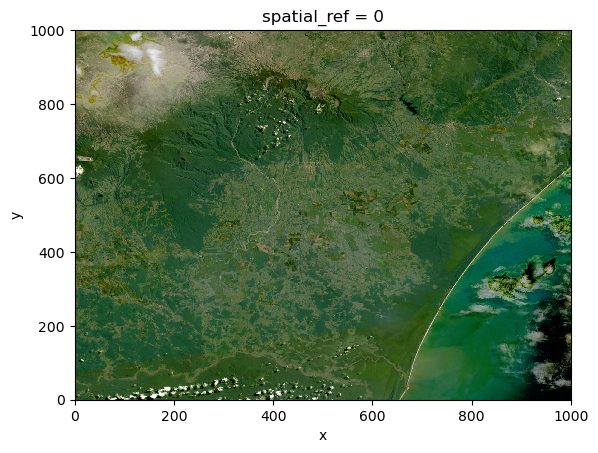

In [48]:
browse.plot.imshow()

In [51]:
import os
os.environ["GDAL_HTTP_COOKIEFILE"] = "./cookies.txt"
os.environ["GDAL_HTTP_COOKIEJAR"] = "./cookies.txt"

In [52]:
# Banda 4
b_04 = rioxarray.open_rasterio(assets_landsat["B04"].href)

b_04

<xarray.DataArray (band: 1, y: 3660, x: 3660)>
[13395600 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 8e+05 8e+05 8.001e+05 ... 9.097e+05 9.098e+05
  * y            (y) float64 1.2e+06 1.2e+06 1.2e+06 ... 1.09e+06 1.09e+06
    spatial_ref  int64 0
Attributes: (12/36)
    ACCODE:                    Lasrc; Lasrc
    add_offset:                0.0
    AREA_OR_POINT:             Area
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    ...                        ...
    TIRS_SSM_MODEL:            UNKNOWN; UNKNOWN
    TIRS_SSM_POSITION_STATUS:  UNKNOWN; UNKNOWN
    ULX:                       799980
    ULY:                       1200000
    USGS_SOFTWARE:             LPGS_15.6.0
    _FillValue:                -9999

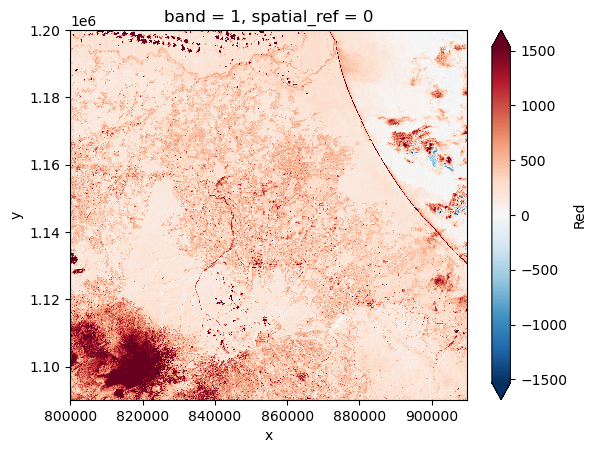

In [53]:
b_04.plot(robust=True)

In [55]:
# Bandas necesarias para el cálculo
b_red = rioxarray.open_rasterio(assets_landsat["B04"].href)
b_nir = rioxarray.open_rasterio(assets_landsat["B05"].href)

In [57]:
# Dimensiones de las bandas
print(b_red.shape, b_nir.shape)

(1, 3660, 3660) (1, 3660, 3660)


In [58]:
# Cálculo del NDVI
ndvi = (b_nir - b_red)/ (b_nir + b_red)

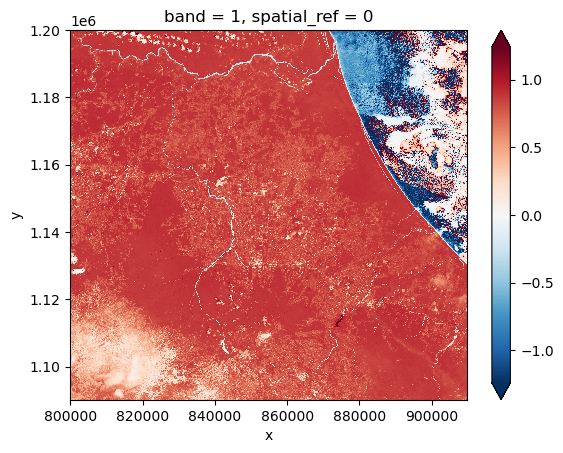

In [59]:
# Visualización del cálculo del NDVI
ndvi.plot(robust=True)

In [60]:
ndvi.rio.to_raster("ndvi_landsat.tif")

### *Assets*

Cada item retornado contiene un conjunto de "activos" (*assets*) (ej. bandas) que también pueden accederse mediante el API.

In [ ]:
# Activos (assets) del item
assets = item.assets

# Llaves
assets.keys()

In [ ]:
# Contenido completo de los items
assets.items()

In [ ]:
# Nombres de los activos
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

In [ ]:
# Imagen thumbnail
assets["thumbnail"]

In [ ]:
# URL del thumbnail
assets["thumbnail"].href

## Visualización

In [ ]:
# Carga de rioxarray, para graficar datos raster
import rioxarray

El módulo rioxarray provee un conjunto de funciones para manipular imágenes.

Las bandas pueden abrirse con la función [open_rasterio()](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray-open-rasterio) y graficarse con [plot()](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.plot.html#xarray.DataArray.plot) y [plot.imshow()](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.plot.imshow.html).

#### Visualización del `overview`

El `overview` es una imagen de tres bandas tipo "True Color".

In [ ]:
# Vista general de la imagen (True Color)
overview = rioxarray.open_rasterio(item.assets['overview'].href)

overview

In [ ]:
# Dimensiones de la imagen (bandas, filas, columnas)
overview.shape

In [ ]:
# Graficación de imagen RGB
overview.plot.imshow(figsize=(8, 8))

#### Visualización de una banda

In [ ]:
# Banda 9
b_09 = rioxarray.open_rasterio(assets["B09"].href)

b_09

In [ ]:
# Graficación de la banda
# robust=True calcula el rango de colores entre los percentiles 2 y 98
b_09.plot(robust=True)

## Ejemplo de álgebra raster: cálculo del NDVI

Seguidamente, se utiliza la imagen Sentinel para calcular el [Índice de vegetación de diferencia normalizada (NDVI)](https://es.wikipedia.org/wiki/%C3%8Dndice_de_vegetaci%C3%B3n_de_diferencia_normalizada).

Se separan las dos bandas necesarias para el cálculo: la roja y la infrarroja cercana.

In [ ]:
# Bandas necesarias para el cálculo
b_red = rioxarray.open_rasterio(assets["B04"].href)
b_nir = rioxarray.open_rasterio(assets["B8A"].href)

Para efectos del ejemplo, se reduce el área en la que va a realizarse el cálculo.

In [ ]:
# Buffer (rectángulo) de 15 km alrededor de un punto
point = Point(859872, 1168852)
bbox = point.buffer(15000).bounds

# Recorte 
b_red_clip = b_red.rio.clip_box(*bbox)
b_nir_clip = b_nir.rio.clip_box(*bbox)

In [ ]:
# Visualización de la banda roja
b_red_clip.plot(robust=True, cmap="Reds")

In [ ]:
# Visualización de la banda infrarroja cercana
b_nir_clip.plot(robust=True, cmap="Reds")

In [ ]:
# Dimensiones de las bandas
print(b_red_clip.shape, b_nir_clip.shape)

Para realizar la operación algebraica, las bandas deben tener las mismas dimensiones. Así que se reduce la resolución de la banda roja para hacerla igual a la resolución de la infrarroja cercana.

In [ ]:
# Se homogeneizan las dimensiones
b_red_clip_matched = b_red_clip.rio.reproject_match(b_nir_clip)
print(b_red_clip_matched.shape)

Ya puede calcularse el NDVI.

In [ ]:
# Cálculo del NDVI
ndvi = (b_nir_clip - b_red_clip_matched)/ (b_nir_clip + b_red_clip_matched)

In [ ]:
# Visualización del cálculo del NDVI
ndvi.plot(robust=True)

## Escritura

La función [to_raster()](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray.raster_array.RasterArray.to_raster) exporta los datos a un archivo raster.

In [ ]:
# Se guarda el resultado del cálculo del NDVI en un archivo
# ndvi.rio.to_raster("ndvi.tif")

## Recursos de interés

- [The Carpentries Incubator - Introduction to Geospatial Raster and Vector Data with Python](https://carpentries-incubator.github.io/geospatial-python/)
- [Geospatial Raster & Vector Data with Python](https://www.youtube.com/watch?v=Ce7GuGIf3r0)